In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans


data = pd.read_csv('songs_matrix.csv', low_memory=False)

data['frequency'] = pd.to_numeric(data['frequency'], errors='coerce')
data['popularity'] = pd.to_numeric(data['popularity'], errors='coerce')
data['mean'] = pd.to_numeric(data['mean'], errors='coerce')

In [3]:
cluster = data[['frequency','popularity','mean']]
cluster.describe()

,frequency,popularity,mean
count,127771.000000,127771.000000,127771.000000
mean,15.653004,54.151051,3.208899
std,54.576728,193.885957,1.071008
min,1.000000,1.000000,1.000000
25%,2.000000,7.000000,2.517241
50%,5.000000,15.000000,3.333333
75%,10.000000,34.500000,4.000000
max,1904.000000,6428.000000,5.000000


In [4]:
clustervar=cluster.copy()
clustervar['frequency']=preprocessing.scale(clustervar['frequency'].astype('float64'))
clustervar['popularity']=preprocessing.scale(clustervar['popularity'].astype('float64'))
clustervar['mean']=preprocessing.scale(clustervar['mean'].astype('float64'))

In [5]:
clus_train, clus_test = train_test_split(clustervar, test_size=.3, random_state=123)

In [6]:
from scipy.spatial.distance import cdist
clusters = range(1,10)
meandist = []

for k in clusters:
    model = KMeans(n_clusters = k)
    model.fit(clus_train)
    clusassign = model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / clus_train.shape[0])


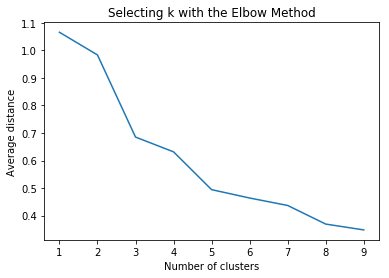

In [11]:
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')
plt.show()

In [7]:
model3 = KMeans(n_clusters=3)
model3.fit(clus_train)
clusassign = model3.predict(clus_train)

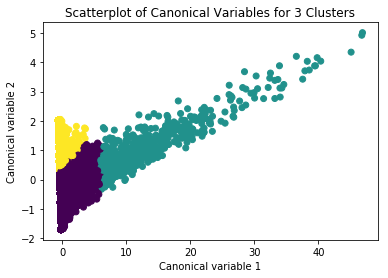

In [8]:
from sklearn.decomposition import PCA
pca_2 = PCA(2)
plt.figure()
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

In [46]:
clus_train.reset_index(level=0, inplace=True)

cluslist = list(clus_train['index'])

labels = list(model3.labels_)

newlist = dict(zip(cluslist, labels))

In [47]:
newclus = pd.DataFrame.from_dict(newlist, orient='index')


In [11]:
newclus.columns = ['cluster']

In [48]:
newclus.reset_index(level=0, inplace=True)
merged_train = pd.merge(clus_train, newclus, on='index')
merged_train.head(n=10)

,level_0,index,frequency,popularity,mean,0
0,0,40946,1.417221,1.464005,0.397300,0
1,1,125997,-0.066934,-0.088460,-0.117241,0
2,2,68830,-0.231840,-0.243191,-0.817519,2
3,3,8172,-0.066934,-0.016252,0.972080,0
4,4,25396,-0.231840,-0.263821,-2.062457,2
5,5,54025,-0.176871,-0.160668,0.583036,0
6,6,45257,-0.066934,-0.042041,0.583036,0
7,7,30229,-0.268486,-0.274137,-2.062457,2
8,8,42573,-0.195194,-0.170983,0.925394,0
9,9,17398,-0.121902,-0.129721,0.012440,0


In [13]:
merged_train.cluster.value_counts()

0    60765
2    27909
1      765
Name: cluster, dtype: int64

In [23]:
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
clustergrp

Clustering variable means by cluster


,level_0,index,frequency,popularity,mean
cluster,,,,,
0,44732.500864,63782.218958,-0.020743,-0.006410,0.553638
1,45092.014379,63535.318954,8.584780,8.567171,0.333878
2,44679.380666,64028.846035,-0.187566,-0.218721,-1.211128


In [16]:
data_train=pd.DataFrame(data)
data_train.reset_index(level=0, inplace=True)
merged_train_all=pd.merge(data_train, merged_train, on='index')


In [17]:
merged_train_all = merged_train_all.drop(columns=["index","level_0","frequency_y","popularity_y","mean_y","cluster_x"]).rename(columns={"frequency_x":"frequency","popularity_x":"popularity","mean_x":"mean"})
merged_train_all.head(10)

,song_id,frequency,popularity,mean,cluster_y
0,0,5,14,2.800000,2
1,1,2,5,2.500000,2
2,3,18,47,2.611111,2
3,4,2,9,4.500000,0
4,7,9,27,3.000000,0
5,8,4,19,4.750000,0
6,10,2,8,4.000000,0
7,12,48,154,3.208333,0
8,13,4,5,1.250000,2
9,16,3,7,2.333333,2


In [18]:
train_data_to_describe = merged_train_all[['frequency','popularity','mean','cluster_y']]
train_data_to_describe.groupby("cluster_y").describe()

frequency                                                      \
              count        mean         std    min    25%    50%    75%   
cluster_y                                                                 
0           60765.0   14.520908   27.841616    1.0    3.0    6.0   13.0   
1             765.0  484.180392  266.928003  228.0  304.0  395.0  568.0   
2           27909.0    5.416317    7.794447    1.0    2.0    3.0    6.0   

                      mean             ...                       popularity  \
              max    count      mean   ...         75%       max      count   
cluster_y                              ...                                    
0           280.0  60765.0  3.801848   ...    4.181818  5.000000    60765.0   
1          1904.0    765.0  3.566484   ...    3.815686  4.378947      765.0   
2           215.0  27909.0  1.911776   ...    2.500000  2.857143    27909.0   

                                                                           
                  mean         std    min     25%     50%     75%     max  
cluster_y                                                                  
0            52.908237   99.999378    3.0    10.0    21.0    46.0   938.0  
1          1715.198693  935.740616  712.0  1084.0  1400.0  2024.0  6428.0  
2            11.744384   18.313386    1.0     3.0     7.0    14.0   426.0  

[3 rows x 24 columns]

In [19]:
train_data_to_describe.cluster_y.value_counts()

0    60765
2    27909
1      765
Name: cluster_y, dtype: int64

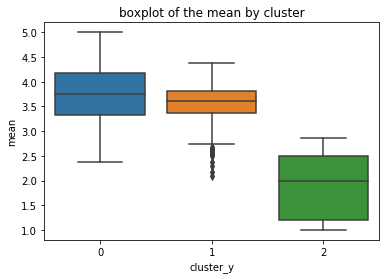

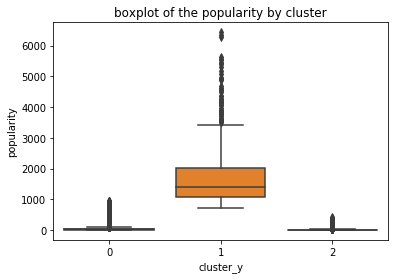

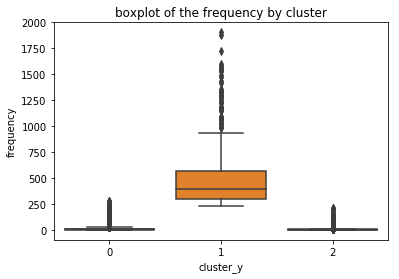

In [45]:
# Boxplot of the mean
mean_boxplot = sns.boxplot(x="cluster_y", y="mean",data=train_data_to_describe)
mean_boxplot.set_title("boxplot of the mean by cluster")
plt.show()
#Boxplot of the popularity
pop_boxplot = sns.boxplot(x="cluster_y", y="popularity",data=train_data_to_describe)
pop_boxplot.set_title("boxplot of the popularity by cluster")
plt.show()

#Boxplot of the frequency
freq_boxplot = sns.boxplot(x="cluster_y", y="frequency",data=train_data_to_describe)
freq_boxplot.set_title("boxplot of the frequency by cluster")
plt.show()

## Conclusion
-  cluster 1: very popular songs
-  cluster 0: songs with average popularity
-  cluster 2: practically unknown songs 